1. Theory Questions:

Q1: Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.

The minimax loss function essentially treats GAN training as a competitive two player game where the generator and discriminator fight over a shared objective. In this setup, the discriminator tries to maximize the value function by accurately distinguishing between real data and the generator's fakes, while the generator simultaneously works to minimize that same value by producing outputs realistic enough to fool its opponent. This adversarial dynamic forces both networks to improve simultaneously as the discriminator gets better at spotting fakes, the generator must learn to create more convincing data to succeed, ultimately aiming to produce samples that are indistinguishable from reality

Q2: What is mode collapse, Why can mode collapse occur during GAN training? and
how can it be mitigated?

Mode collapse happens when a GAN generator creates a very limited range of repetitive outputs rather than capturing the diversity of the real dataset. This occurs because the adversarial training process is highly unstable if the generator finds a specific weakness in the discriminator or if one network overpowers the other, it may exploit that single weakness repeatedly rather than learning new patterns. To fix this, researchers use stabilization techniques like Batch Normalization or Minibatch Discrimination, and often switch to architectural variants like Wasserstein GAN (WGAN), which uses a different distance metric to ensure smoother, more stable training.

Q3: Explain the role of the discriminator in adversarial training?

The discriminator acts as a strict critic or detective within the GAN framework, tasked with classifying inputs as either "real" (from the actual dataset) or "fake" (created by the generator). By constantly trying to minimize its own classification error and catch the generator's forgeries, it provides the necessary competitive pressure that forces the generator to learn and produce increasingly realistic data.

Q4: How do metrics like IS and FID evaluate GAN performance?

IS evaluates whether the generated images are distinct and diverse enough to be clearly classified, while FID statistically compares the features of generated images against real ones, where a lower score confirms the model is successfully mimicking the training data.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
# Load and preprocess data
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset \
  .from_tensor_slices(train_images) \
  .shuffle(BUFFER_SIZE) \
  .batch(BATCH_SIZE)

# Generator model
def make_generator_model():
  model = tf.keras.Sequential([
    layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((7, 7, 256)),
    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])
  return model

# Discriminator model
def make_discriminator_model():
  model = tf.keras.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1)
  ])
  return model

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training function
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, 100])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)
# Run the training
train(train_dataset, epochs=50)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2. Coding Assignment:

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

# Create a directory to save images if it doesn't exist
if not os.path.exists('generated_images'):
    os.makedirs('generated_images')

# Load and preprocess data
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.reshape(-1, 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset \
  .from_tensor_slices(train_images) \
  .shuffle(BUFFER_SIZE) \
  .batch(BATCH_SIZE)

# Generator model
def make_generator_model():
  model = tf.keras.Sequential([
    layers.Dense(4*4*256, use_bias=False, input_shape=(100,)), # Adjusted for 32x32 output
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((4, 4, 256)), # Adjusted for 32x32 output
    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])
  return model

# Discriminator model
def make_discriminator_model():
  model = tf.keras.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]), # Changed input shape for CIFAR-10
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1)
  ])
  return model

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
seed = tf.random.normal([16, 100])

# Training function
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, 100])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
      plt.axis('off')
  plt.savefig(f'generated_images/image_at_epoch_{epoch:04d}.png')
  plt.close(fig)

# Training loop
def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)

    # Generate and save images every 10 epochs
    if (epoch + 1) % 10 == 0:
      generate_and_save_images(generator, epoch + 1, seed)
      print(f'Epoch {epoch + 1} completed. Images saved.')

# Run the training
train(train_dataset, epochs=50)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10 completed. Images saved.
Epoch 20 completed. Images saved.
Epoch 30 completed. Images saved.
Epoch 40 completed. Images saved.
Epoch 50 completed. Images saved.


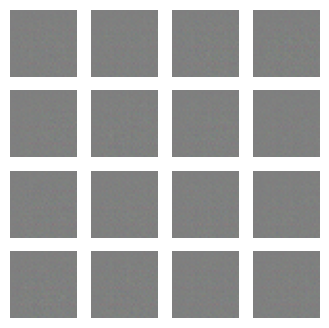

Final generated images saved.


In [ ]:
generate_and_save_images(generator, 50, seed)
print('Final generated images saved.')